<a href="https://colab.research.google.com/github/Cutie-tee/Roboreviews_project/blob/main/Clustering_with_zero_classifcation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset consists of 3 files: 1429_1.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv




In [ ]:
combined_data['reviews.username'] = combined_data['reviews.username'].fillna("Anonymous")
combined_data['name'] = combined_data['name'].fillna("Unknown")

combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].map({'Yes': True, 'No': False})

assert combined_data['reviews.rating'].between(1, 5).all()

combined_data.to_csv('final_preprocessed_reviews.csv', index=False)
print("Final preprocessed dataset saved.")



Final preprocessed dataset saved.


**Sentinent analysis  with RoBerta-base**

**Clustering based on emrging trends to ascertain partner growth opportuntities** . Lifestyle Enhancers:

Products designed to improve daily routines or convenience.
Includes items like Nespresso pods, smart assistants, pet carriers, and other gadgets that simplify life.
Creative and Productivity Tools:

Products for work, study, or creative activities.
Includes laptops, tablets, keyboards, laptop stands, webcams, and styluses.
Health and Wellness:

Devices that focus on personal health, fitness, or beauty.
Includes fitness trackers, electric massagers, hairdryers, and grooming devices.
Entertainment and Immersion:

Products that provide entertainment or enhanced experiences.
Includes gaming consoles, headphones, speakers, VR headsets, and streaming devices.
Power and Connectivity Solutions:

Products that enable devices to stay powered or connected.
Includes chargers, batteries, power banks, docking stations, and USB hubs.
Eco-Friendly and Sustainable Solutions:

Products marketed as sustainable or environmentally friendly.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import what we need
from transformers import pipeline
import pandas as pd
import torch
from datasets import Dataset
from tqdm.notebook import tqdm

# Print if we have a GPU
print("Checking if we have a GPU...")
if torch.cuda.is_available():
    print("Yes! Found GPU!")
    BATCH_SIZE = 8
else:
    print("No GPU found - will be slower")
    BATCH_SIZE = 4

# Set up AI classifier
print("Setting up the AI...")
classifier = pipeline(
    "zero-shot-classification",
    model="cross-encoder/nli-deberta-v3-large",
    device=0 if torch.cuda.is_available() else -1
)

#Product clusters for reviews
categories = [
    "Daily Convenience",
    "Creative and Productivity Tools",
    "Health and Wellness",
    "Entertainment and Immersion",
    "Power and Connectivity Solutions",
    "Eco-Friendly and Sustainable Solutions"
]

# Function to classify reviews
def classify_text(examples):
    try:
        outputs = classifier(
            examples["reviews.text"],
            candidate_labels=categories,
            batch_size=BATCH_SIZE
        )

        # Get the top category for each review
        return {
            "category": [output["labels"][0] for output in outputs]
        }
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return {"category": ["Error"] * len(examples["reviews.text"])}

# Process data in chunks (since DeBERTa uses more memory)
print("\nStarting to process reviews...")
chunk_size = 5000  # Process 5000 reviews at a time

for i, chunk_df in enumerate(pd.read_csv('final_preprocessed_reviews.csv', chunksize=chunk_size)):
    print(f"\nProcessing chunk {i+1}")

    # Convert chunk to dataset
    chunk_dataset = Dataset.from_pandas(chunk_df)

    # Process chunk
    classified_chunk = chunk_dataset.map(
        classify_text,
        batched=True,
        batch_size=BATCH_SIZE,
        remove_columns=chunk_dataset.column_names,
        desc=f"Classifying chunk {i+1}"
    )

    # Convert results back to DataFrame
    chunk_results = pd.DataFrame({
        'reviews.text': chunk_df['reviews.text'],
        'category': classified_chunk['category']
    })

    # Save results (append after first chunk)
    chunk_results.to_csv('classified_reviews.csv',
                        mode='a' if i > 0 else 'w',
                        header=i == 0,
                        index=False)

    print(f"Finished chunk {i+1}")

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nAll done! Check 'classified_reviews.csv' for results")

# Show some examples
print("\nHere are some example results:")
try:
    examples = pd.read_csv('classified_reviews.csv', nrows=3)
    for i, row in examples.iterrows():
        print(f"\nReview {i+1}:")
        print(f"Text: {row['reviews.text'][:100]}...")  # First 100 characters
        print(f"Category: {row['category']}")
except:
    print("Couldn't read the results file")

Checking if we have a GPU...
Yes! Found GPU!
Setting up the AI...


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.




Starting to process reviews...

Processing chunk 1


Classifying chunk 1:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 1

Processing chunk 2


Classifying chunk 2:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 2

Processing chunk 3


Classifying chunk 3:   0%|          | 0/5000 [00:00<?, ? examples/s]

To validate my model's classification , i will analyse the words  that appear more often in each product category, you can perform text analysis on the classified reviews

In [ ]:
# 1. Load and Group Classified Data
import pandas as pd

# Load the classified data
classified_data = pd.read_csv('classified_reviews.csv')

# Group reviews by category
grouped_reviews = classified_data.groupby('category')['reviews.text'].apply(lambda texts: " ".join(texts))

#2. Tokenise and count the words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

# Define the vectorizer with stop words as a list
stop_words = list(set(stopwords.words('english')))  # Convert set to list
vectorizer = CountVectorizer(stop_words=stop_words)

# Create a word frequency matrix for each category
word_counts = {}
for category, text in grouped_reviews.items():
    word_count_matrix = vectorizer.fit_transform([text])
    word_counts[category] = dict(zip(vectorizer.get_feature_names_out(), word_count_matrix.toarray()[0]))


#3 Sort the word frequencies to find the most common words in each category.
# Extract the top N words for each category
top_n = 10  # Top N words to display
top_words_by_category = {
    category: sorted(words.items(), key=lambda item: item[1], reverse=True)[:top_n]
    for category, words in word_counts.items()
}

# Print the results
for category, top_words in top_words_by_category.items():
    print(f"\nTop {top_n} words for category '{category}':")
    for word, freq in top_words:
        print(f"  {word}: {freq}")

#5. Visualize the most frequent words for each category using bar plots.
import matplotlib.pyplot as plt

for category, top_words in top_words_by_category.items():
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.title(f"Top {top_n} Words for Category: {category}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()




To identify and remove overlapping words per category, i will
To handle overlapping words (words that appear frequently across multiple categories), Filter Out Overlapping Words and set a frequency threshold A word must appear at least k times more in one category than in others to be considered unique.

In [ ]:
#Identify Overlapping Words
from collections import defaultdict

# Find top N words for each category
top_n = 10
category_top_words = {
    category: sorted(words.items(), key=lambda item: item[1], reverse=True)[:top_n]
    for category, words in word_counts.items()
}

# Create a dictionary of word occurrences across categories
word_occurrences = defaultdict(list)
for category, top_words in category_top_words.items():
    for word, freq in top_words:
        word_occurrences[word].append((category, freq))

# Find overlapping words
overlapping_words = {word: occurrences for word, occurrences in word_occurrences.items() if len(occurrences) > 1}

# Display overlapping words
print("Overlapping Words Across Categories:")
for word, occurrences in overlapping_words.items():
    print(f"\nWord: '{word}'")
    for category, freq in occurrences:
        print(f"  Category: {category}, Frequency: {freq}")


Overlapping Words Across Categories:

Word: 'tablet'
  Category: Creative and Productivity Tools, Frequency: 1023
  Category: Daily Convenience, Frequency: 627
  Category: Eco-Friendly and Sustainable Solutions, Frequency: 207
  Category: Entertainment and Immersion, Frequency: 4273

Word: 'great'
  Category: Creative and Productivity Tools, Frequency: 1020
  Category: Daily Convenience, Frequency: 694
  Category: Eco-Friendly and Sustainable Solutions, Frequency: 549
  Category: Entertainment and Immersion, Frequency: 3627
  Category: Health and Wellness, Frequency: 260
  Category: Power and Connectivity Solutions, Frequency: 691

Word: 'price'
  Category: Creative and Productivity Tools, Frequency: 665
  Category: Daily Convenience, Frequency: 523
  Category: Eco-Friendly and Sustainable Solutions, Frequency: 438
  Category: Entertainment and Immersion, Frequency: 1876
  Category: Health and Wellness, Frequency: 94
  Category: Power and Connectivity Solutions, Frequency: 572

Word: '

In [ ]:
#Remove overlapping words from the word frequency list for each category.

# Remove overlapping words from each category
filtered_word_counts = {
    category: {word: freq for word, freq in words.items() if word not in overlapping_words}
    for category, words in word_counts.items()
}

# Extract top N filtered words for each category
filtered_top_words_by_category = {
    category: sorted(words.items(), key=lambda item: item[1], reverse=True)[:top_n]
    for category, words in filtered_word_counts.items()
}

# Display filtered top words
for category, top_words in filtered_top_words_by_category.items():
    print(f"\nTop {top_n} Filtered Words for Category '{category}':")
    for word, freq in top_words:
        print(f"  {word}: {freq}")



Top 10 Filtered Words for Category 'Creative and Productivity Tools':
  apps: 355
  works: 327
  work: 321
  love: 258
  fire: 257
  like: 248
  would: 231
  books: 219
  buy: 197
  get: 197

Top 10 Filtered Words for Category 'Daily Convenience':
  buy: 266
  love: 247
  fire: 207
  like: 207
  would: 202
  battery: 197
  time: 193
  work: 187
  purchased: 185
  get: 175

Top 10 Filtered Words for Category 'Eco-Friendly and Sustainable Solutions':
  works: 143
  work: 141
  last: 135
  value: 128
  buy: 103
  battery: 98
  like: 96
  far: 91
  brand: 79
  quality: 78

Top 10 Filtered Words for Category 'Entertainment and Immersion':
  love: 1591
  fire: 1165
  kids: 1084
  games: 1053
  loves: 852
  screen: 829
  like: 806
  old: 734
  books: 711
  apps: 710

Top 10 Filtered Words for Category 'Health and Wellness':
  would: 75
  buy: 66
  last: 60
  love: 60
  works: 60
  work: 58
  recommend: 56
  deal: 54
  like: 54
  far: 53

Top 10 Filtered Words for Category 'Power and Connecti

 allow words that overlap but are disproportionately more frequent in one category, set a frequency ratio threshold

In [ ]:
# Define a ratio threshold
overlap_threshold = 2

# Filter overlapping words based on frequency ratio
unique_words = {}
for word, occurrences in overlapping_words.items():
    # Find the maximum frequency and category
    max_category, max_freq = max(occurrences, key=lambda x: x[1])
    total_freq = sum(freq for _, freq in occurrences)

    # If the word is significantly more frequent in one category, keep it
    if max_freq / total_freq > (1 / overlap_threshold):
        unique_words[word] = max_category

# Update filtered word counts to include only unique words
filtered_word_counts_with_threshold = {
    category: {word: freq for word, freq in words.items() if word in unique_words and unique_words[word] == category}
    for category, words in word_counts.items()
}

# Display results
for category, words in filtered_word_counts_with_threshold.items():
    print(f"\nTop Unique Words for Category '{category}':")
    for word, freq in words.items():
        print(f"  {word}: {freq}")



Top Unique Words for Category 'Creative and Productivity Tools':

Top Unique Words for Category 'Daily Convenience':
  easy: 599
  one: 300

Top Unique Words for Category 'Eco-Friendly and Sustainable Solutions':
  product: 209

Top Unique Words for Category 'Entertainment and Immersion':
  amazon: 1341
  bought: 1595
  great: 3627
  kindle: 1329
  tablet: 4273
  use: 1655

Top Unique Words for Category 'Health and Wellness':

Top Unique Words for Category 'Power and Connectivity Solutions':
  long: 273


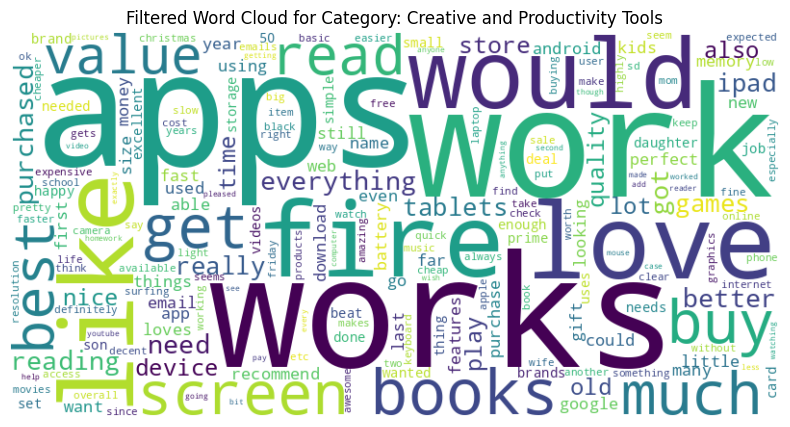

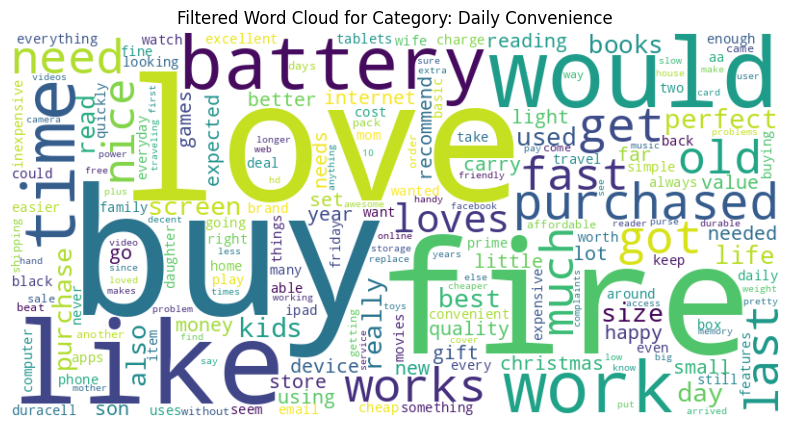

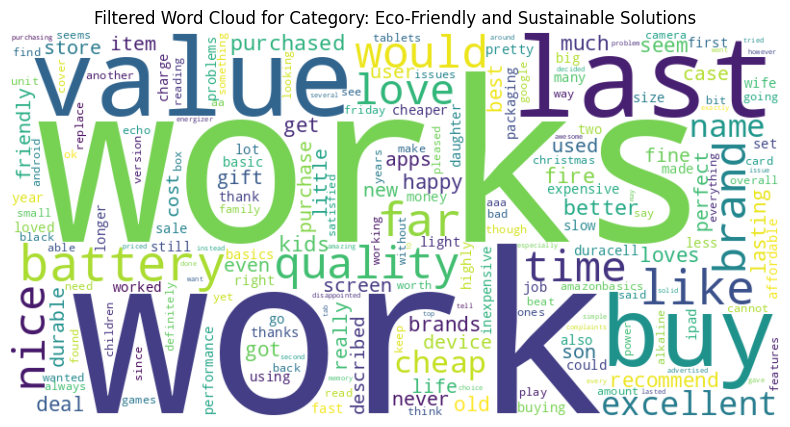

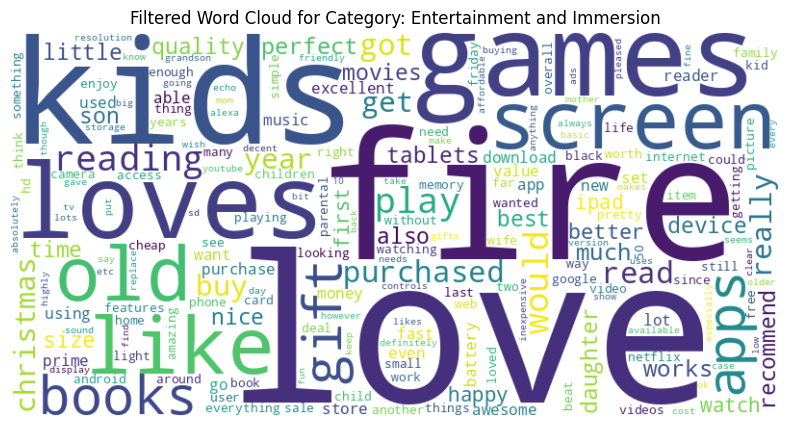

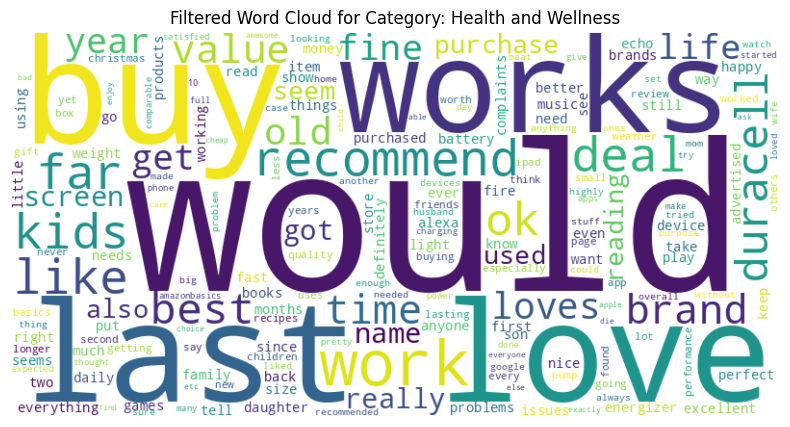

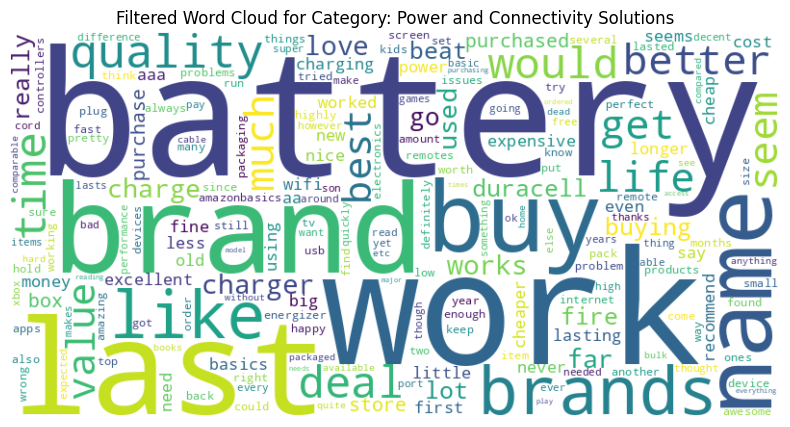

In [ ]:
#final results
from wordcloud import WordCloud

for category, words in filtered_word_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Filtered Word Cloud for Category: {category}")
    plt.show()


In [ ]:
import squarify

# Prepare data for treemap
treemap_data = []
for category, words in filtered_word_counts.items():
    for word, freq in words.items():
        treemap_data.append({"Category": category, "Word": word, "Frequency": freq})

df_treemap = pd.DataFrame(treemap_data)

# Create treemap
fig = px.treemap(
    df_treemap,
    path=["Category", "Word"],
    values="Frequency",
    title="Treemap of Word Frequencies by Category"
)
fig.show()


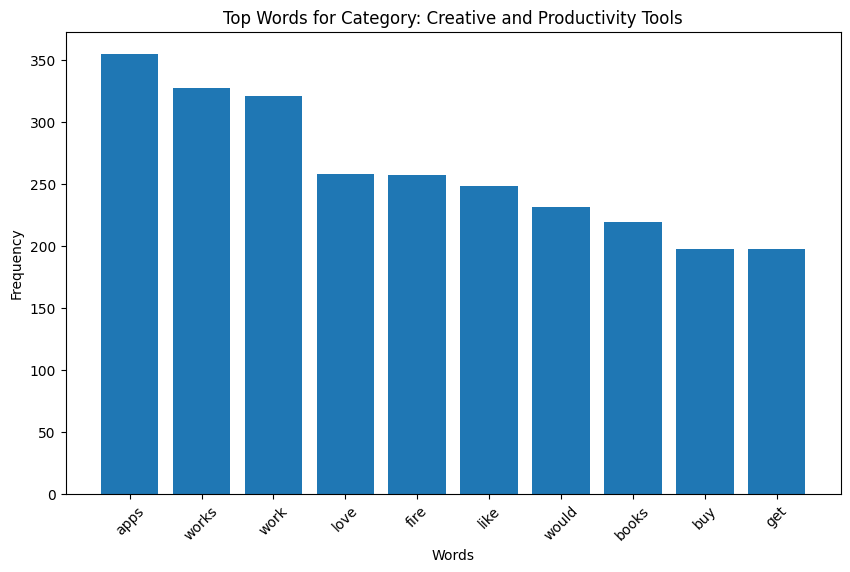

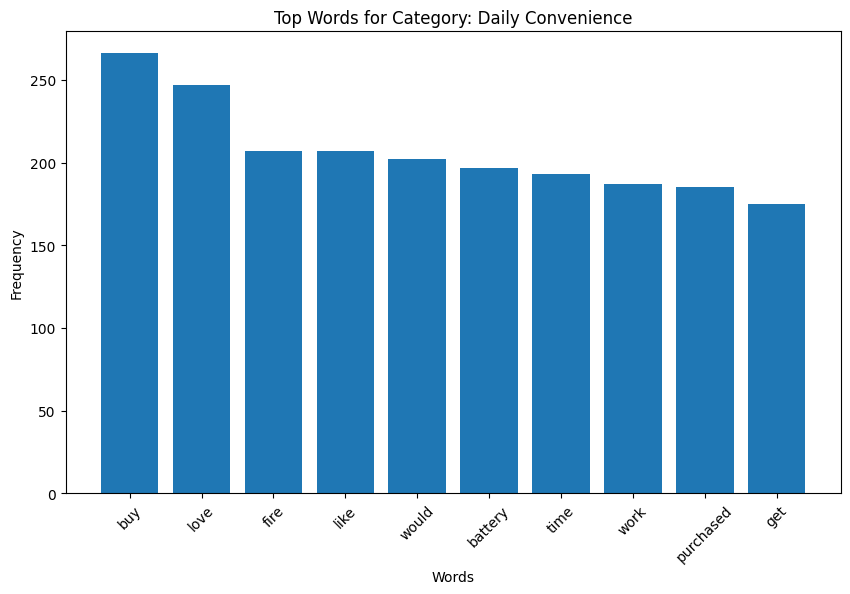

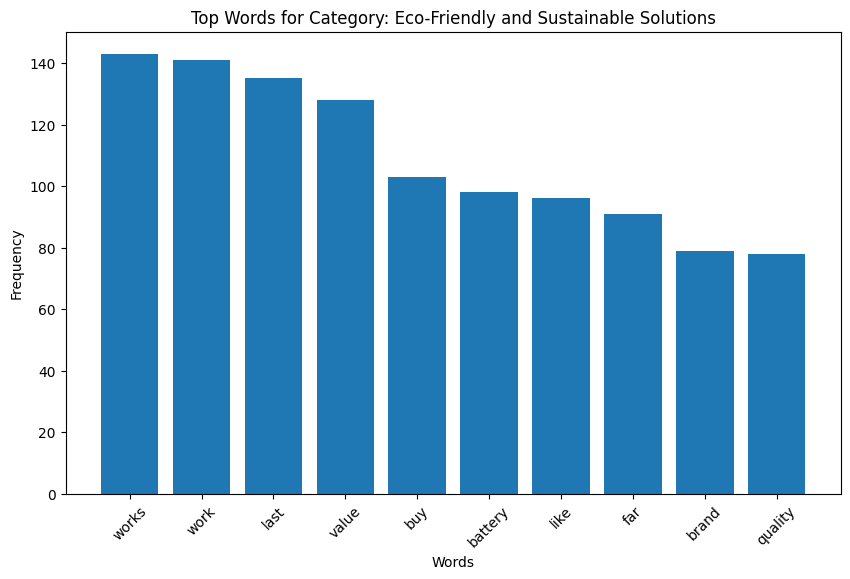

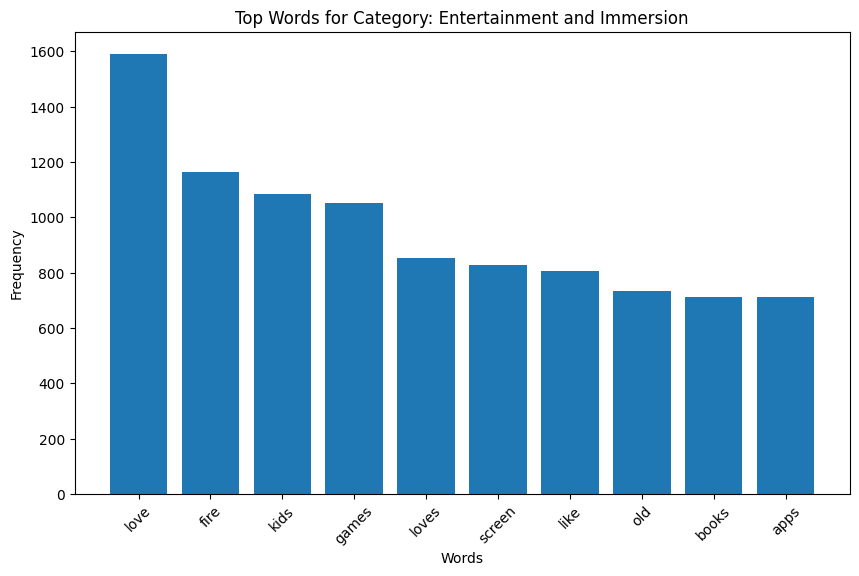

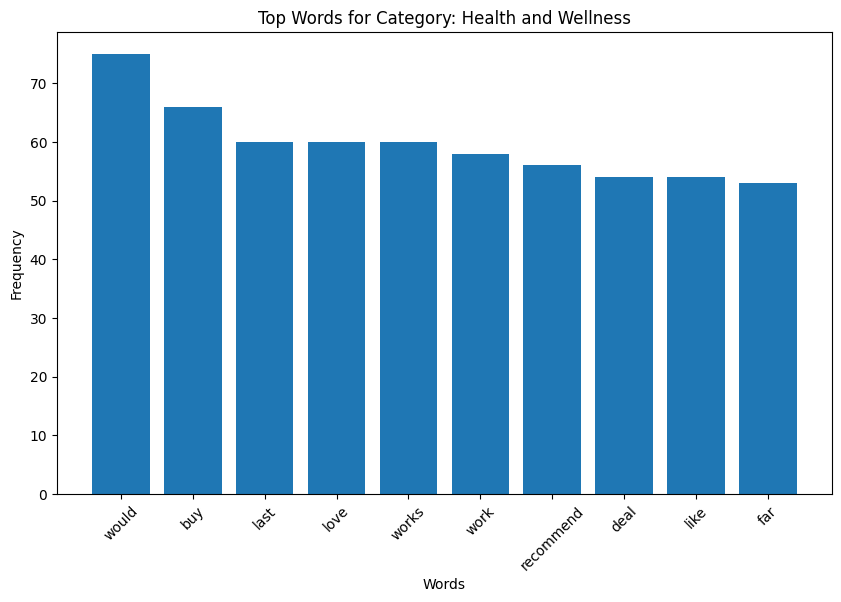

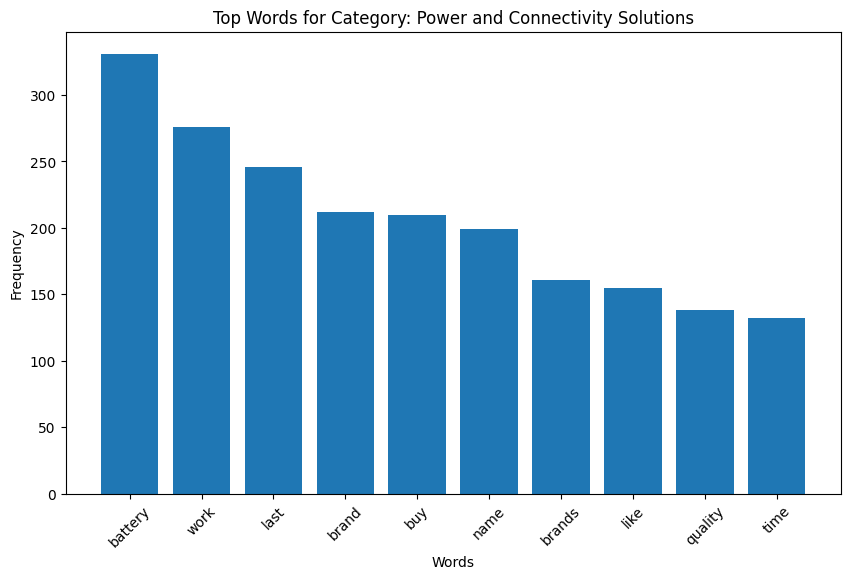

In [23]:
import matplotlib.pyplot as plt

# Plot bar charts for each category
for category, words in filtered_word_counts.items():
    top_words = sorted(words.items(), key=lambda x: x[1], reverse=True)[:10]
    words, frequencies = zip(*top_words)

    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.title(f"Top Words for Category: {category}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()


Testing the model